# AutoCNet Demo Notebook

This first cell is largely book keeping and environment setup. The second line places a configuration file into the environment that provides URLs, paths, and login information for the services that AutoCNet uses, as well as information about the spatial reference system the project is going to use.

Lines 4-6 get the USGS Community Sensor Model plugin loaded and ready for use.


In [1]:
import os
os.environ['autocnet_config'] = '/home/tgiroux/.autocnet/demo.yml'
os.environ['PROJ_LIB'] = '/home/tgiroux/anaconda3/envs/autocnet/share/proj' #point to you local environment path
os.environ['ISISROOT'] = '/usgs/cpkgs/anaconda3_linux/envs/isis3.8.0-RC1'

import ctypes
from ctypes.util import find_library
ctypes.CDLL(find_library('usgscsm'))

from autocnet.graph.network import NetworkCandidateGraph

/home/tgiroux/anaconda3/envs/autocnet/lib/python3.7/site-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


The primary way to use AutoCNet is through the CandidateGraph object. In this demo, the derived, NetworkCandidateGraph is used. This object has an identical interface to the CandidateGraph. The difference lies in where the data are stored. In the CandidateGraph everything is stored in memory and all processing occurs in serial. On the NetworkCandidateGraph, data are stored in a database and processing occurs either in serial or on a compute cluster. 

Below, the `from_filelist` method is used to perform an initial database populate. A few things are happening here behind the scenes:

* The database (name specified in the configuration file) is being created if it does not already exist. This creates all of the tables, relationships, and triggers.
* The `images` table is being populated with metadata about the images in the file list including a lat/lon footprint.
* The `cameras` table is being populated with a CSM compliant state string.

For a one-and-done style project, this cell should be run once.

In [2]:
# First run
import glob
#ncg = NetworkCandidateGraph.from_filelist(glob.glob('/scratch/tgiroux/ctx_og_cubes/adam_ctx/*.cub'))
ncg = NetworkCandidateGraph()

In [3]:
ncg.config_from_file('/home/tgiroux/.autocnet/demo.yml')
ncg.from_filelist(glob.glob('/scratch/tgiroux/ctx_og_cubes/adam_ctx/*.cub'))

loading 1 of 71
loading 2 of 71
loading 3 of 71
loading 4 of 71
loading 5 of 71
loading 6 of 71
loading 7 of 71
loading 8 of 71
loading 9 of 71
loading 10 of 71
loading 11 of 71
loading 12 of 71
loading 13 of 71
loading 14 of 71
loading 15 of 71
loading 16 of 71
loading 17 of 71
loading 18 of 71
loading 19 of 71
loading 20 of 71
loading 21 of 71
loading 22 of 71
loading 23 of 71
loading 24 of 71
loading 25 of 71
loading 26 of 71
loading 27 of 71
loading 28 of 71
loading 29 of 71
loading 30 of 71
loading 31 of 71
loading 32 of 71
loading 33 of 71
loading 34 of 71
loading 35 of 71
loading 36 of 71
loading 37 of 71
loading 38 of 71
loading 39 of 71
loading 40 of 71
loading 41 of 71
loading 42 of 71
loading 43 of 71
loading 44 of 71
loading 45 of 71
loading 46 of 71
loading 47 of 71
loading 48 of 71
loading 49 of 71
loading 50 of 71
loading 51 of 71
loading 52 of 71
loading 53 of 71
loading 54 of 71
loading 55 of 71
loading 56 of 71
loading 57 of 71
loading 58 of 71
loading 59 of 71
loadin

The cell below is the primary mechanism for accessing an existing project. Here, the `from_database` class method is used. This method makes a spatial query to the `images` table and builds a graph object where the nodes are images and the edges linking nodes indicate that the footprints overlap. This call makes no modifications to the database.

In [4]:
# On subsequent runs
ncg.from_database()

<AxesSubplot:>

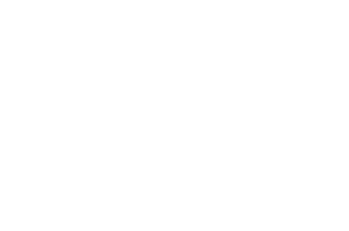

In [6]:
from matplotlib import pyplot as plt
ncg.plot()

In [10]:
ncg.nodes()

NodeView(())

The database currently contains a populated `images` table and a populated `cameras` table. In the current pipeline style flow, we now need to compute polygons generated by the overlaps of footprints. It is within those polygons that correspondences can be found. We run two SQL queries (found in the `sql` directory).

The first query computes the n-wise overlapping polygons and the second query identifies those polygons that contributed to the overlapping geometry. The picture below illustrates what the result looks like.

![overlap](overlap.png)

Each polygon (A, B, AB, ABC, BC) will be an independent row in the database. The `intersections` column will be populated with an array where the values in the array are the `id`s of the image that contributed to the particular overlap.

In [15]:
# Run the 2 sql commands in the sql directory of the autocnet repo to compute overlaps and get the overlap arrays populates

Once overlaps have been computed, points are placed into the overlapping geometries. This process adds points to the `points` table and measures to the `measures` table. These points and measures are synonymous with the points and measures in an ISIS control network. This code is making use of the `images` and `cameras` tables that have been previously populated.

In [16]:
# This block is used to compute the overlapping polygon components and then place points into them.
from autocnet.spatial.overlap import place_points_in_overlaps

# Place points
place_points_in_overlaps(ncg)

AttributeError: 'NoneType' object has no attribute 'Session'

Next, the points/measures are converted to be pairwise matches between images. Instead of a point-centric representation where a point has many measures, this representation is image-to-image centric where a pair of images has some set of shared correspondences. This command results in the `matches` table being populated with the pairwise matches between edges. Using the above example, all of the points/measures placed in the overlapping ABC polygon are decomposed into matches between AB, AC, and BC. The data are identical, but the representation has changed.

We do this because now we want to use classic computer vision techniques that generally operate best with pairwise representations.

In [ ]:
# This block converts the points into matches
for s, d, e in ncg.edges(data='data'):  # intentionally in a loop so this doesn't spawn a cluster job
    e.network_to_matches()
    

Now that a pairwise representation exists, we apply a standard CV technique (computation of the fundamental matrix (F)). This operation updates the `edges` table to add the F matrix and a mask to the `masks` column indicating whether a particular match has been flagged as a blunder by the ransac procedure. This code is making use of the `matches` table that has been previously populated.

In [ ]:
# This block computes the fundamental matrices
ncg.compute_fundamental_matrices(method='ransac', maskname='fundamental')

Finally, the next three cells are a janky heuristic designed to use the F matrix to remove blunders in the `points` and `measures` tables. This is an aggregation step whereby we seek to determine if a measure should be made inactive. This code makes use of the `edges` table (`masks` column) and updates the `measures` table (`active` column).

These three cells are not well integrated into the NetworkCandidateGraph and provide the best view of the type of operations happening under the hood in the previous steps.

In [5]:
# This block converts the points into matches
counters = []
for s, d, e in ncg.edges(data='data'):  # intentionally in a loop so this doesn't spawn a cluster job
    counters.append(e.mask_to_counter('fundamental'))

NameError: name 'ncg' is not defined

In [6]:
from collections import Counter
from autocnet import Session
from autocnet.io.db.model import Measures

aggregate = sum(counters, Counter())

# Now I need to take the output here and then look in qnet to see wtf is going on. Do we have a threshold here
# for blowing away bad stuff? If so, where? I should probably normalize all of these too based on the number of other
# images that they exist in. In other words, count/n-images
to_pop = []
session = Session()
for k, v in aggregate.items():
    pid = session.query(Measures).filter(Measures.id == k).first().pointid
    nimages = len(session.query(Measures).filter(Measures.pointid == pid).all())
    outlier_ratio = v / nimages  # This is the metric to test on (maybe?) - the ratio of the # of times the measure is 
                                  # flagged as bad to the number of measures associated with the point.
    # These are rules that are going to need testing / vetting. Are these appropriate values?
    if outlier_ratio <= 0.5 or (outlier_ratio <= 0.5 and nimages == 2):
        to_pop.append(k)
    else:
        aggregate[k] = v / len(session.query(Measures).filter(Measures.pointid == pid).all())
for k in to_pop:
    aggregate.pop(k)

ImportError: cannot import name 'Session' from 'autocnet' (/home/tgiroux/repos/autocnet/autocnet/__init__.py)

In [7]:
session = Session()
make_inactive = list(aggregate.keys())
session.query(Measures).filter(Measures.id.in_(make_inactive)).update({'active':False}, synchronize_session='fetch')
session.commit()

NameError: name 'Session' is not defined

In [8]:
ncg.to_isis('/scratch/jlaura/elysium_subset/demo.net')

NameError: name 'ncg' is not defined